In [46]:
# %%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, LSTM, Bidirectional,
    RepeatVector, TimeDistributed, Concatenate, Attention
)
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.regularizers import l2
from keras_tuner import HyperParameters, Hyperband
import os

# Carregar dados
data = pd.read_csv("dataset.csv")

# Converter 'id' em datetime e definir como índice
data['timestamp'] = pd.to_datetime(data['id'], errors='coerce')
data.set_index('timestamp', inplace=True)

# Selecionar variáveis
variables = data[['ws100', 'humid', 'wdisp100', 'hour', 'wdir100']]

# Padronização dos dados usando MinMaxScaler
scaler = MinMaxScaler()
variables_scaled = scaler.fit_transform(variables)

# Parâmetros
sequence_length = 36  # janela de aprendizado de 36
num_target_steps = 6  # previsão para 6
split_ratio = 0.8  # 80% treinamento, 20% teste

# Divisão dos dados em treinamento e teste
split_index = int(len(variables_scaled) * split_ratio)
train_data = variables_scaled[:split_index]
test_data = variables_scaled[split_index:]

# Função para preparar sequências de dados
def create_sequences(data, seq_length, num_target_steps):
    X, y = [], []
    for i in range(len(data) - seq_length - num_target_steps + 1):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length:i+seq_length+num_target_steps, 0])  # ws100 é a primeira coluna
    return np.array(X), np.array(y)

# Criar sequências para treinamento e teste
X_train, y_train = create_sequences(train_data, sequence_length, num_target_steps)
X_test, y_test = create_sequences(test_data, sequence_length, num_target_steps)

# Reshape de y_train e y_test para serem compatíveis com a saída do modelo
y_train = y_train.reshape(-1, num_target_steps, 1)
y_test = y_test.reshape(-1, num_target_steps, 1)

# Valores mínimos e máximos de 'ws100' para inversão da escala
ws100_min = scaler.data_min_[0]
ws100_max = scaler.data_max_[0]

num_features = X_train.shape[2]

Definição de funções de perdas customizadas.

In [47]:
# %%
# Calcular a distribuição das velocidades do vento no conjunto de treinamento
ws100_train = train_data[:, 0]  # ws100 é a primeira coluna
hist, bin_edges = np.histogram(ws100_train, bins=100)

# Calcular a frequência inversa para cada bin
freq = hist / np.sum(hist)
weights = 1 / (freq + 1e-6)  # Adicionar um pequeno valor para evitar divisão por zero
weights = weights / np.max(weights)  # Normalizar pesos para que o máximo seja 1

def custom_mse(y_true, y_pred):
    return tf.reduce_mean(tf.square(y_true - y_pred))

def custom_mae(y_true, y_pred):
    return tf.reduce_mean(tf.abs(y_true - y_pred))

def custom_rmse(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    return tf.sqrt(mse)

def custom_mape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    return tf.reduce_mean(tf.abs((y_true - y_pred) / tf.maximum(tf.abs(y_true), epsilon))) * 100

def custom_weighted_mse(y_true, y_pred):
    # Definir os pesos para cada passo de previsão
    weights = tf.constant([1.0, 1.0, 1.0, 1.0, 1.0, 2.0], dtype=tf.float32)  # Peso maior para o sexto passo
    
    # Expandir dimensões para corresponder a y_true e y_pred
    weights = tf.reshape(weights, (1, -1, 1))
    # Calcular o erro quadrático ponderado
    loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss

def custom_progressive_mse(y_true, y_pred):
    # Criar um vetor de pesos crescentes
    weights = tf.cast(tf.range(1, num_target_steps + 1), dtype=tf.float32)
    
    # Normalizar pesos para que a soma seja igual ao número de passos
    weights = weights / tf.reduce_mean(weights)
    
    # Expandir dimensões
    weights = tf.reshape(weights, (1, -1, 1))
    
    # Calcular o erro quadrático ponderado
    loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss

def custom_focal_mse(y_true, y_pred):
    gamma = 2.0  # Parâmetro de foco
    mse = tf.square(y_true - y_pred)
    focal_mse = tf.pow(mse, gamma)
    loss = tf.reduce_mean(focal_mse)
    return loss

def custom_combined_loss(y_true, y_pred):
    # Erro quadrático médio global
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Erro absoluto médio no sexto passo
    mae_sixth = tf.reduce_mean(tf.abs(y_true[:, 5, :] - y_pred[:, 5, :]))
    
    # Combinar as perdas com pesos
    loss = mse + mae_sixth * 2  # Peso maior para o erro no sexto passo
    return loss

def custom_uncertainty_weighted_mse(y_true, y_pred):
    # Exemplo de variâncias estimadas para cada passo
    variances = tf.constant([0.5, 0.6, 0.8, 1.0, 1.2, 1.5], dtype=tf.float32)
    
    # Pesos inversamente proporcionais à variância
    weights = 1.0 / variances
    
    # Normalizar pesos
    weights = weights / tf.reduce_mean(weights)
    weights = tf.reshape(weights, (1, -1, 1))
    
    # Calcular a perda ponderada
    loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss

# Função para obter o peso de acordo com o valor de ws100
def get_weight(value):
    # Encontrar o bin correspondente ao valor
    bin_index = np.searchsorted(bin_edges, value) - 1
    bin_index = np.clip(bin_index, 0, len(weights) - 1)
    return weights[bin_index]

# Função de perda personalizada com pesos baseados na distribuição
def custom_distribution_weighted_mse(y_true, y_pred):
    # Obter os pesos para y_true
    weights_vector = tf.numpy_function(get_weight, [y_true], tf.float64)
    weights_vector = tf.cast(weights_vector, tf.float32)
    # Calcular o erro quadrático ponderado
    loss = tf.reduce_mean(weights_vector * tf.square(y_true - y_pred))
    return loss

def custom_log_cosh_loss(y_true, y_pred):
    return tf.reduce_mean(tf.math.log(tf.cosh(y_pred - y_true + 1e-12)))

def custom_temporal_weighted_loss(y_true, y_pred):
    weights = tf.cast(tf.range(1, num_target_steps + 1), dtype=tf.float32)
    weights = weights / tf.reduce_mean(weights)
    weights = tf.reshape(weights, (1, -1, 1))
    loss = tf.reduce_mean(weights * tf.square(y_true - y_pred))
    return loss

def custom_higher_power_mae(y_true, y_pred):
    power = 3  # Ajuste para 3 ou 4 conforme necessário
    loss = tf.reduce_mean(tf.pow(tf.abs(y_true - y_pred), power))
    return loss

def custom_msle(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()
    y_true_clipped = tf.clip_by_value(y_true, epsilon, None)
    y_pred_clipped = tf.clip_by_value(y_pred, epsilon, None)
    first_log = tf.math.log(y_true_clipped + 1.0)
    second_log = tf.math.log(y_pred_clipped + 1.0)
    loss = tf.reduce_mean(tf.square(first_log - second_log))
    return loss

def custom_huber_loss(y_true, y_pred):
    delta = 0.1  # Delta pequeno
    error = y_true - y_pred
    abs_error = tf.abs(error)
    quadratic = tf.minimum(abs_error, delta)
    linear = abs_error - quadratic
    loss = tf.reduce_mean(0.5 * tf.square(quadratic) + delta * linear)
    return loss

def custom_exponential_error(y_true, y_pred):
    loss = tf.reduce_mean(tf.exp(tf.abs(y_true - y_pred)))
    return loss


custom_objects = {
    'custom_mse': custom_mse,
    'custom_weighted_mse': custom_weighted_mse,
    'custom_progressive_mse': custom_progressive_mse,
    'custom_focal_mse': custom_focal_mse,
    'custom_combined_loss': custom_combined_loss,
    'custom_uncertainty_weighted_mse': custom_uncertainty_weighted_mse,
    'custom_mae': custom_mae,
    'custom_rmse': custom_rmse,
    'custom_mape': custom_mape,
    'custom_distribution_weighted_mse': custom_distribution_weighted_mse,
    'custom_higher_power_mae': custom_higher_power_mae,
    'custom_temporal_weighted_loss': custom_temporal_weighted_loss,
    'custom_msle': custom_msle,
    'custom_huber_loss': custom_huber_loss,
    'custom_exponential_error': custom_exponential_error
    
}


Geração do modelo usando LSTM bidirecional

In [48]:
def build_model_bidirectional_seq2seq_with_attention(hp):
    units = hp.Int('units', min_value=128, max_value=256, step=32)
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])
    dropout_rate = 0.3 
    num_layers = 1
    # hp.Int('num_layers', min_value=1, max_value=2, step=1)
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    
    # Seleção do Otimizador
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'rmsprop':
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    num_features = X_train.shape[2]
    
    # Encoder
    encoder_inputs = Input(shape=(sequence_length, num_features), name='encoder_inputs')
    encoder_outputs = encoder_inputs
    for i in range(num_layers):
        encoder_outputs = Bidirectional(LSTM(
            units=units,
            return_sequences=True,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'encoder_lstm_{i}'
        ))(encoder_outputs)
        encoder_outputs = LayerNormalization(name=f'encoder_norm_{i}')(encoder_outputs)
    
    # Contexto de Atenção
    context_vector = encoder_outputs  # Usaremos as saídas do encoder para a atenção
    
    # Decoder
    decoder_inputs = RepeatVector(num_target_steps)(encoder_outputs[:, -1, :])  # Usar o último passo do encoder
    decoder_outputs = decoder_inputs
    for i in range(num_layers):
        decoder_outputs = LSTM(
            units=units * 2,
            return_sequences=True,
            dropout=dropout_rate,
            kernel_regularizer=l2(1e-3),
            name=f'decoder_lstm_{i}'
        )(decoder_outputs)
        decoder_outputs = LayerNormalization(name=f'decoder_norm_{i}')(decoder_outputs)
    
    # Aplicar Atenção
    attention_output = Attention(name='attention_layer')([decoder_outputs, context_vector])
    decoder_combined_context = Concatenate(axis=-1)([decoder_outputs, attention_output])
    
    # Camada de Saída
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(decoder_combined_context)
    
    # Definição do Modelo
    model = Model(inputs=encoder_inputs, outputs=outputs, name='Bidirectional_LSTM_Seq2Seq_with_Attention')
    
    # Compilação do Modelo com a Função de Perda Customizada
    model.compile(
        optimizer=optimizer,
        loss=custom_higher_power_mae,
        metrics=[
            custom_weighted_mse,
            custom_progressive_mse,
            custom_focal_mse,
            custom_combined_loss,
            custom_uncertainty_weighted_mse        
        ]
    )
    
    return model

In [49]:
def build_bidirectional_lstm_model(hp):
    # Hiperparâmetros
    units = hp.Int('units', min_value=128, max_value=256, step=32)
    learning_rate = hp.Choice('learning_rate', [1e-4, 1e-3])
    dropout_rate = 0.3
    optimizer_choice = hp.Choice('optimizer', ['adam', 'rmsprop'])
    
    # Seleção do Otimizador
    if optimizer_choice == 'adam':
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    else:
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    
    # Definição do Modelo
    inputs = Input(shape=(sequence_length, num_features), name='inputs')
    
    # Camada LSTM Bidirecional com return_sequences=True
    x = Bidirectional(LSTM(
        units=units,
        return_sequences=True,  # Garante que a saída tenha a mesma quantidade de passos de tempo
        dropout=dropout_rate,
        kernel_regularizer=l2(1e-3),
        name='bidirectional_lstm'
    ))(inputs)
    
    # Camada de Saída TimeDistributed
    outputs = TimeDistributed(Dense(1, activation='linear'), name='output_layer')(x)
    
    # Construção do Modelo
    model = Model(inputs=inputs, outputs=outputs, name='Simple_Bidirectional_LSTM')
    
    # Compilação do Modelo
    model.compile(
        optimizer=optimizer,
        loss=custom_higher_power_mae,  # Substitua pela função de perda desejada
        metrics=[
            custom_weighted_mse,
            custom_progressive_mse,
            custom_focal_mse,
            custom_combined_loss,
            custom_uncertainty_weighted_mse        
        ]
    )
    
    return model

Hypertunning do modelo para gerar os melhores parêmetros

In [50]:
hp = HyperParameters()

#Definir o tuner para a primeira etapa de treinamento
tuner_stage1 = Hyperband(
    build_bidirectional_lstm_model,
    objective='val_loss',
    max_epochs=20,
    factor=3,
    directory='tuner_dir_stage1',
    project_name='wind_speed_prediction_stage1'
)

early_stopping_stage1 = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Primeira Etapa de Treinamento
tuner_stage1.search(
    X_train, y_train,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_stage1]
)

# Obter o melhor modelo da primeira etapa
best_model_stage1 = tuner_stage1.get_best_models(num_models=1)[0]

# Salvar o modelo da primeira etapa
model_save_path_stage1 = 'best_model_stage1.h5.keras'
best_model_stage1.save(model_save_path_stage1)

# Segunda Etapa de Treinamento (Fine-tuning)
# Carregar o modelo da primeira etapa
model_finetune = load_model(model_save_path_stage1, custom_objects=custom_objects)

# Compilar o modelo com a nova função de perda ponderada
model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=custom_higher_power_mae,
    metrics=[
        custom_mae,
        custom_rmse,
        custom_mape        
    ]
)

# Treinar o modelo na segunda etapa
early_stopping_stage2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_finetune = model_finetune.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_stage2]
)

# Salvar o modelo final
model_save_path_final = 'best_model_final.h5.keras'
model_finetune.save(model_save_path_final)

Trial 2 Complete [00h 00m 01s]

Best val_loss So Far: None
Total elapsed time: 00h 00m 01s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
192               |128               |units
0.0001            |0.001             |learning_rate
rmsprop           |adam              |optimizer
3                 |3                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/3


Traceback (most recent call last):
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in 

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/tmp/ipykernel_4599/393372069.py", line 110, in custom_higher_power_mae
    loss = tf.reduce_mean(tf.pow(tf.abs(y_true - y_pred), power))
ValueError: Dimensions must be equal, but are 6 and 36 for '{{node compile_loss/custom_higher_power_mae/sub}} = Sub[T=DT_FLOAT](data_1, Simple_Bidirectional_LSTM_1/output_layer_1/transpose_1)' with input shapes: [?,6,1], [?,36,1].


In [ ]:
# Obter o melhor modelo da primeira etapa
best_model_stage1 = tuner_stage1.get_best_models(num_models=1)[0]

# Salvar o modelo da primeira etapa
model_save_path_stage1 = 'best_model_stage1.h5.keras'
best_model_stage1.save(model_save_path_stage1)

# Segunda Etapa de Treinamento (Fine-tuning)
# Carregar o modelo da primeira etapa
model_finetune = load_model(model_save_path_stage1, custom_objects=custom_objects)

# Compilar o modelo com a nova função de perda ponderada
model_finetune.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=custom_higher_power_mae,
    metrics=[
        custom_mae,
        custom_rmse,
        custom_mape        
    ]
)

# Treinar o modelo na segunda etapa
early_stopping_stage2 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_finetune = model_finetune.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping_stage2]
)

# Salvar o modelo final
model_save_path_final = 'best_model_final.h5.keras'
model_finetune.save(model_save_path_final)

/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 2 variables whereas the saved optimizer has 17 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Epoch 1/50


/home/lucas/Projetos/TFG-Vento-Sul/.venv/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 17 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 52ms/step - custom_mae: 0.0717 - custom_mape: 59817.9805 - custom_rmse: 0.0942 - loss: 0.0022 - val_custom_mae: 0.0788 - val_custom_mape: 23.2566 - val_custom_rmse: 0.0968 - val_loss: 0.0026
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - custom_mae: 0.0714 - custom_mape: 133530.2031 - custom_rmse: 0.0939 - loss: 0.0021 - val_custom_mae: 0.0716 - val_custom_mape: 20.5676 - val_custom_rmse: 0.0893 - val_loss: 0.0022
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - custom_mae: 0.0695 - custom_mape: 73464.3828 - custom_rmse: 0.0914 - loss: 0.0018 - val_custom_mae: 0.0900 - val_custom_mape: 26.8046 - val_custom_rmse: 0.1100 - val_loss: 0.0033
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - custom_mae: 0.0698 - custom_mape: 83348.6328 - custom_rmse: 0.0926 - loss: 0.0019 - val_custom_mae: 0.0803 - val_custom_mape: 23.7636 - val_custom_rmse: 0.0984 - val_loss: 0.0025
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - custom_mae: 0.0698

Avaliação e plotagem dos gráficos.

46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Passo 1:
MAE: 0.7607
RMSE: 1.0523
MAPE: 10.21%



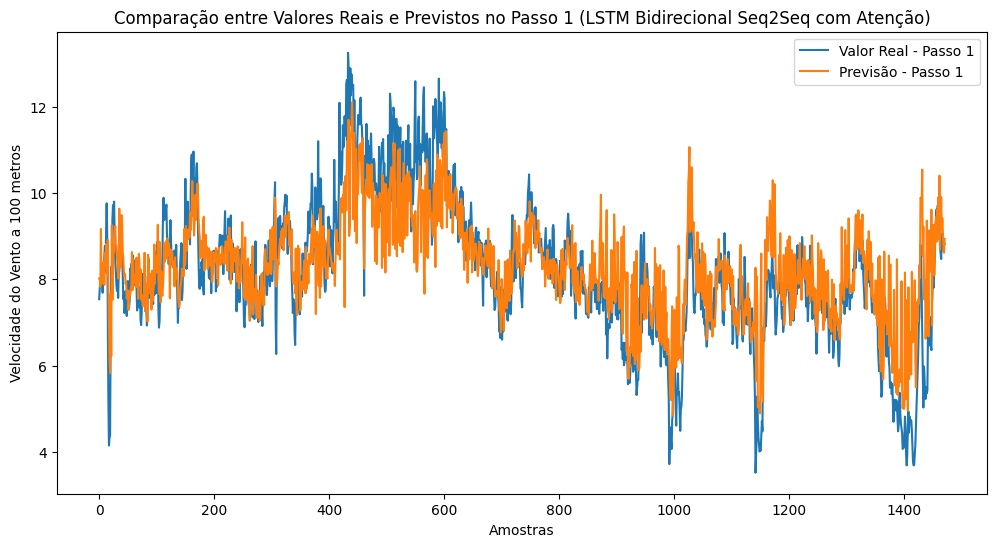

Passo 2:
MAE: 0.8287
RMSE: 1.1415
MAPE: 11.28%



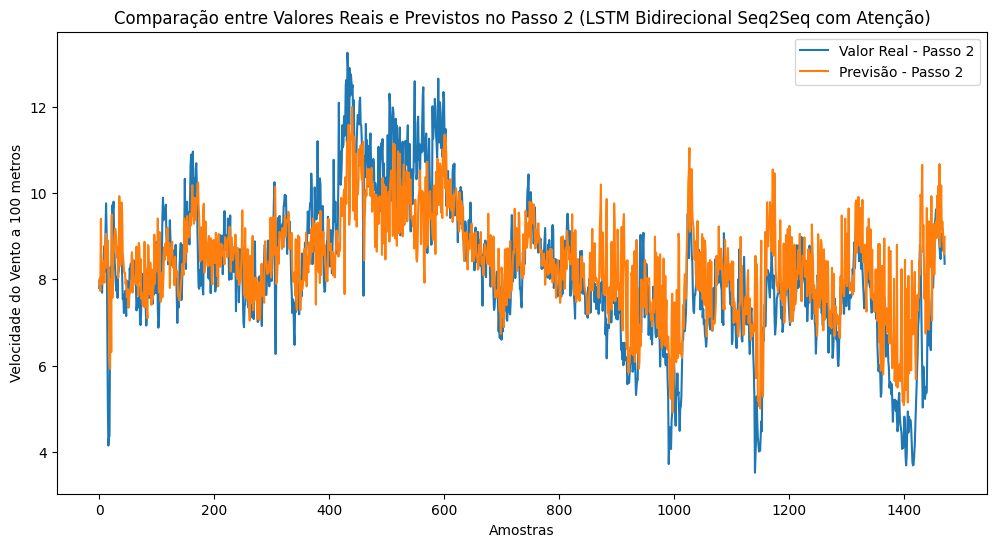

Passo 3:
MAE: 0.8701
RMSE: 1.1925
MAPE: 11.87%



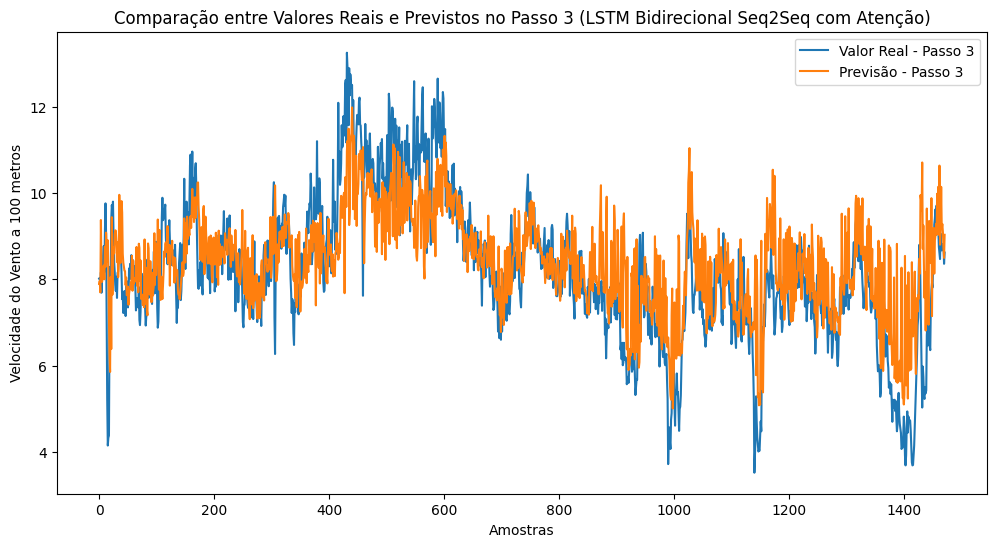

Passo 4:
MAE: 0.8955
RMSE: 1.2144
MAPE: 12.21%



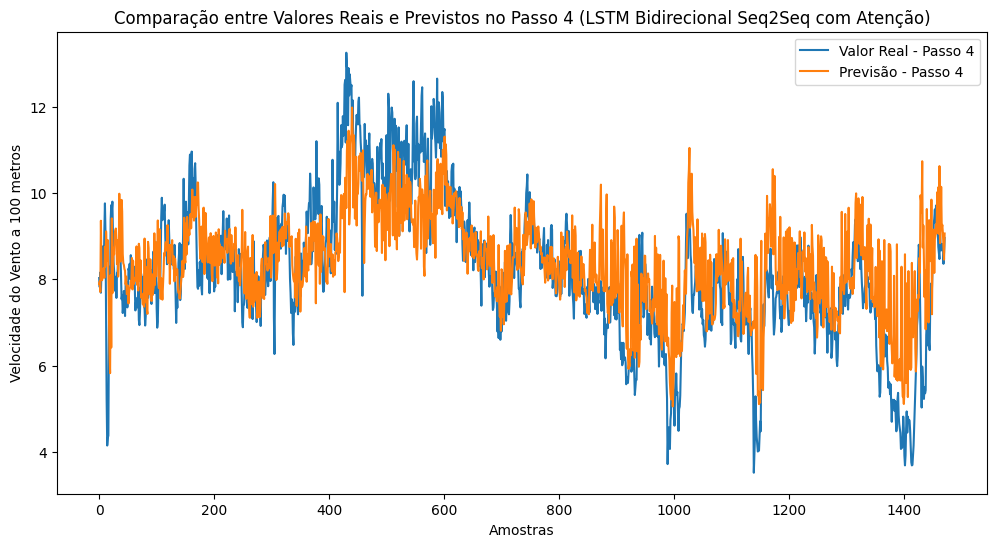

Passo 5:
MAE: 0.9221
RMSE: 1.2459
MAPE: 12.55%



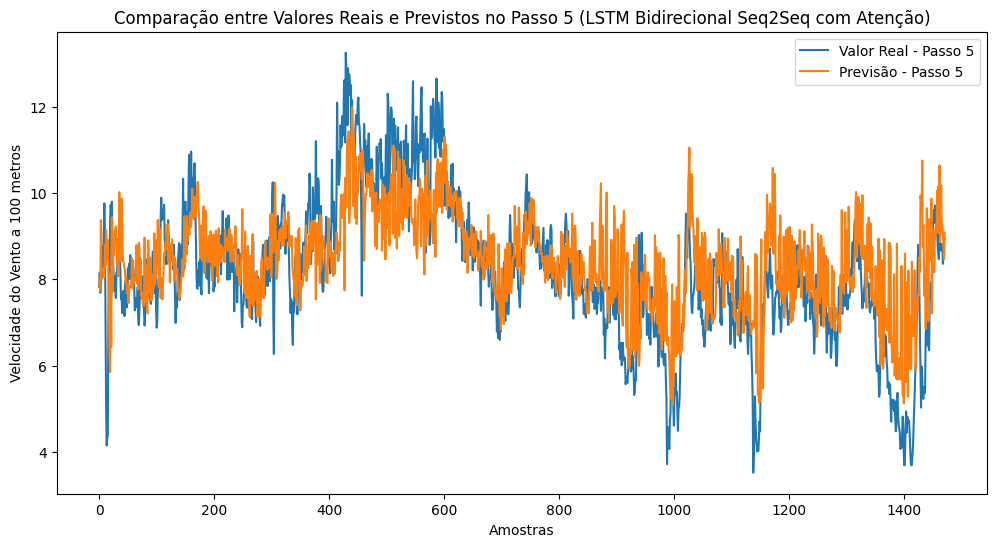

Passo 6:
MAE: 0.9335
RMSE: 1.2542
MAPE: 12.69%



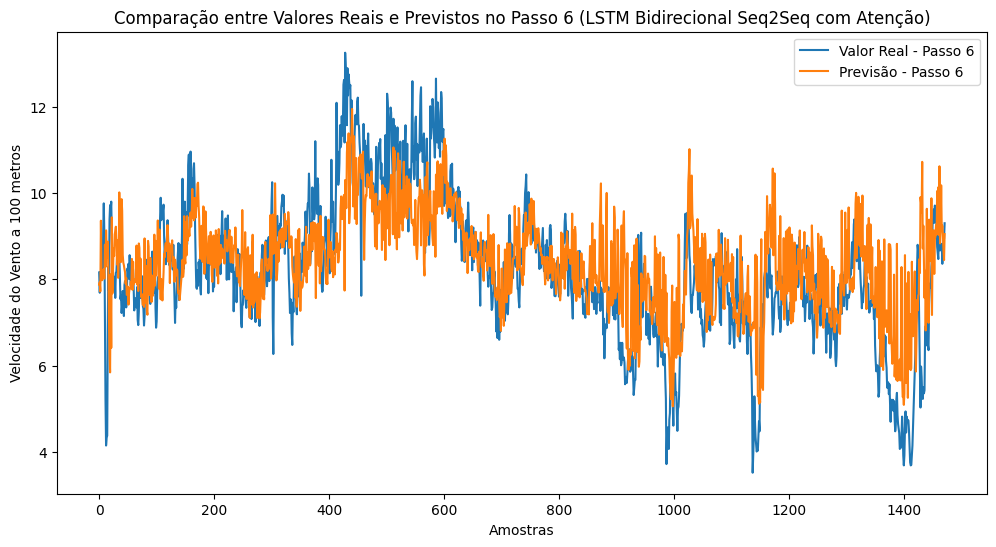

In [ ]:
# Carregar o modelo final
loaded_model = load_model(model_save_path_final, custom_objects=custom_objects)

# Avaliação no conjunto de teste
y_pred = loaded_model.predict(X_test)

# Inversão da padronização
ws100_min = scaler.data_min_[0]
ws100_max = scaler.data_max_[0]

y_pred_inv = y_pred * (ws100_max - ws100_min) + ws100_min
y_test_inv = y_test * (ws100_max - ws100_min) + ws100_min

num_target_steps = y_test.shape[1]  # Número de passos de previsão

# Avaliação e plotagem para cada passo de previsão
for step in range(num_target_steps):
    y_test_step = y_test_inv[:, step, 0]
    y_pred_step = y_pred_inv[:, step, 0]
    
    mae = mean_absolute_error(y_test_step, y_pred_step)
    rmse = np.sqrt(mean_squared_error(y_test_step, y_pred_step))
    mape = np.mean(np.abs((y_test_step - y_pred_step) / np.maximum(y_test_step, 1e-6))) * 100  # Evitar divisão por zero
    
    print(f"Passo {step+1}:")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAPE: {mape:.2f}%\n")
    
    # Plotagem das previsões para o passo atual
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_step, label=f'Valor Real - Passo {step+1}')
    plt.plot(y_pred_step, label=f'Previsão - Passo {step+1}')
    plt.legend()
    plt.title(f'Comparação entre Valores Reais e Previstos no Passo {step+1} (LSTM Bidirecional Seq2Seq com Atenção)')
    plt.xlabel('Amostras')
    plt.ylabel('Velocidade do Vento a 100 metros')
    plt.show()

## O que fazer:

Você tem que falar sobre LSTM, LSTM bidirecional, LSTM encoder-decoder, Loss customizáveis, método automático de seleção do loss.
